In [1]:
from pathlib import Path
from matplotlib import pyplot as plt

import pysam 
import numpy as np
from Bio import SeqIO
import time 
import matplotlib.patches as patches
import matplotlib.cm as cm
import itertools
from tabulate import tabulate
import csv
import random

np.set_printoptions(threshold=np.inf)
min_quality_score = 8



assembly_ = open("/private/groups/migalab/dan/reference/hg002v1.0.1.fasta", "r")

start_time = time.time()

#Load the reference genome and make it into a dictionary 
fasta_sequences = SeqIO.parse(assembly_, "fasta")
assembly={}
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    assembly[name] = sequence

#Make a dictionary for all the chromosomes and their corresponding sequence length 
assembly_sequence_length = {}    
for chromosome in assembly:
    assembly_sequence_length[chromosome] = len(assembly[chromosome])
    
end_time = time.time()
elapsed_time = end_time - start_time
print (elapsed_time, "seconds")
assembly_.close()



58.30815243721008 seconds


In [2]:
CDR_regions = '/private/groups/migalab/dan/data_analysis/young_old_analysis/HG002_DiMeLo_CENPA_youngpassage.hmmCDR_only_CDR_Dan_certified.bed'
output_dir = Path('/private/groups/migalab/dan/data_analysis/HG002_figure2/b_revised_multi_region')
CENPA_AS_bam_file = '/private/groups/migalab/dan/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1/20240611_1126_1H_PAW33460_814408d8/pod5/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1_5mA_6mC_winnowmap_MD_mA_mC.bam'
ref_genome_file = Path('/private/groups/migalab/dan/reference/hg002v1.0.1.fasta')


In [3]:
''' here in the code, I am formulating the CDR regions and listing the CDRs in each and every chromosome'''
input_file = '/private/groups/migalab/dan/data_analysis/young_old_analysis/HG002_DiMeLo_CENPA_youngpassage.hmmCDR_only_CDR_Dan_certified.bed'
CDR_dict = {}
with open(input_file, 'r') as infile:  
    for i in infile:
        chr_num = i.split('\t')[0]
        CDR_start = i.split('\t')[1]
        CDR_end = i.split('\t')[2].split('\n')[0]
        if chr_num not in CDR_dict:
            CDR_dict[chr_num] = [[CDR_start ,CDR_end]]
        elif chr_num in CDR_dict:  
            CDR_dict[chr_num].append ([CDR_start ,CDR_end])





In [9]:
# Open the BAM file
bamfile = pysam.AlignmentFile(CENPA_AS_bam_file, "rb")

def read_spans_regions(read, regions, thres):
    start_list = []
    span_count = 0
    for region in regions:
        start = int(region[0]) 
        end = int(region[1]) 
        mid_point = (end + start) / 2 
        
        # Calculate coverage range based on the threshold
        coverage_range = (end - start) * (thres / 100) / 2
        threshold_start = mid_point - coverage_range
        threshold_end = mid_point + coverage_range
        
        # Check if the read spans the threshold region
        if read.reference_start <= threshold_start and read.reference_end >= threshold_end:
            span_count += 1
            start_list.append(start)

    return span_count, start_list



# Bins to store read names
spanning_reads = {}
non_spanning_reads = []

# Iterate over chromosomes in the dictionary
for chromosome, regions in CDR_dict.items():
    for read in bamfile.fetch(chromosome):
        if read.query_length > 50000:
            span_count,start_list = read_spans_regions(read, regions,50)
            if span_count >= 2: 
                spanning_reads[read.query_name] = start_list




# Print the bins
print("Reads spanning two or more regions:")



[W::hts_idx_load3] The index file is older than the data file: /private/groups/migalab/dan/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1/20240611_1126_1H_PAW33460_814408d8/pod5/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1_5mA_6mC_winnowmap_MD_mA_mC.bam.csi


Reads spanning two or more regions:


In [10]:
'''
The idea of this function is to isolate the the desired regions (here in the function, it is called the subset) in the mod 
numpy array without dashes(insertions)'''

def mod_subset_producing_step (mod_no_dash,alignment_dash,target_start_no_dash,target_end_no_dash):
    #mod_no_dash = is the numpy array of the mod without any insertions and deletions
    # alignment_dash = is the alignment sequence with the dashes in it 
    # target_start = it's the subset starting position WITHOUT the dashes!!! 


    # Create a mask to identify non-dash positions
    mask = [char != '-' for char in alignment_dash]

    # Generate cumulative counts only for True values in the mask
    cumulative_counts = list(itertools.accumulate(mask))


    
    # Create the final indexes list
    indexes = [count - 1 if is_non_dash else '-' for count, is_non_dash in zip(cumulative_counts, mask)]



    target_start_dash = indexes.index (target_start_no_dash)

        
    try:
        target_end_dash = indexes.index (target_end_no_dash)
    except ValueError: 
        target_end_dash = indexes[-1]




    #obtain dashed alignment 
    alignment_dash_sequence_pre_subset = alignment_dash[0:target_start_dash]
    alignment_dash_sequence_subset = alignment_dash[target_start_dash:target_end_dash]

    #create no dash alignment 
    alignment_no_dash_sequence_pre_subset = alignment_dash_sequence_pre_subset.replace("-","")
    alignment_no_dash_sequence_subset = alignment_dash_sequence_subset.replace("-","")

    subset_no_dash_start = len(alignment_no_dash_sequence_pre_subset)
    subset_no_dash_end = subset_no_dash_start + len(alignment_no_dash_sequence_subset)

    #make mod_no_dash alignment
    mod_subset = mod_no_dash[subset_no_dash_start:subset_no_dash_end]

    return mod_subset





In [11]:
''' 
The input of the function is a dictionary in the format of 'chromosome':[[start,end],[start,end]] 
'''
def region_read_mA_density_calculator (chromosome_coordinates,threshold,mod_tag): 
    read_region_check = {}
    read_CDR_region_distribution = {}


    #get each chromosome
    for chr_name in chromosome_coordinates:

        for region in chromosome_coordinates[chr_name]:
            region_base = 0 

            region_start_index = int(region[0])
            region_end_index = int(region[1])

            
            for read in bamfile.fetch(chr_name,region_start_index,region_end_index):
                chromosome = bamfile.get_reference_name(read.reference_id)
                read_name = read.query_name 
                    
                if read_name in spanning_reads :
                    
                    #make an if statement to check a specific read front, middle, end regions 
                    #setting read start, end, density, length variables 
                        

                    #Get the starting and ending positions of the reads 
                    read_start_position = read.reference_start
                    read_end_position = read.reference_end
                    read_density = 0 

                    
                    #Get sequence information which shows deletions and insertions 
                    sequence = read.get_aligned_pairs(matches_only=False, with_seq = True)


                    #make |a numpy of the sequence length which eliminates the deletion
                    read_sequence_insertion_included = ''
                    genomic_alignment_sequence_deletion_mistach_included = ''
                    
                    for item in sequence:
                        if item[0] is None:
                            read_sequence_insertion_included+='-'
                        elif item[1] is None:
                            genomic_alignment_sequence_deletion_mistach_included += '-'
                        else: 
                            read_sequence_insertion_included+=item[2]
                            genomic_alignment_sequence_deletion_mistach_included +=item[2]

                    
                    #take sequence length excluding insertions 
                    read_sequence_insertion_included = read_sequence_insertion_included.upper()
                    genomic_alignment_sequence_deletion_mistach_included = genomic_alignment_sequence_deletion_mistach_included.upper()
                    
                    genomic_alignment_sequence_deletion_mistach_included_mask = np.array(
                    [char != '-' for char in genomic_alignment_sequence_deletion_mistach_included])

                    insertions = read_sequence_insertion_included.count ("-")
                    no_insertion_no_deletion_sequence_length = len(read_sequence_insertion_included)

                    #make a mod np array with the length of the read length
                    mod=read.modified_bases_forward
                    
                    #make a mod score with its original length 
                    mod_score = np.zeros(len(genomic_alignment_sequence_deletion_mistach_included),)
                    try:
                        if mod_tag == 'A':
                            for indices, values in mod[('A', 0, 'a')]:
                                mod_score[indices] = values
                            mod_score = mod_score[genomic_alignment_sequence_deletion_mistach_included_mask]
                            


                        elif mod_tag == 'CG':
                            for indices, values in mod[('C', 0, 'm')]:
                                mod_score[indices] = values
                            mod_score = mod_score[genomic_alignment_sequence_deletion_mistach_included_mask]
                        
                        if read.is_reverse:
                                mod_score = mod_score[::-1]


                    # No mod would return KeyError 
                    except KeyError:
                        continue
                        


                    # if the regions are longer than the reads 
                    if (region_end_index - region_start_index) > (read_end_position - read_start_position):
                        # if the reads are inside the region
                        if (region_end_index >= read_end_position) and (region_start_index <= read_start_position): 
                            mod_start = 0
                            mod_end = len(read_sequence_insertion_included)
                        
                        # if the reads cover the later part of the region
                        elif (region_end_index < read_end_position) and (region_start_index > read_start_position): 
                            mod_start = 0
                            mod_end = no_insertion_no_deletion_sequence_length - read_end_position - region_end_index

                        # if the reads cover the starting part of the region 
                        elif (region_end_index > read_end_position) and (region_start_index > read_start_position): 
                            mod_start = region_start_index - read_start_position 
                            mod_end = no_insertion_no_deletion_sequence_length

                            
                    
                    # if the reads are longer than the region selected 
                    elif (region_end_index - region_start_index) <= (read_end_position - read_start_position):
                        # scenario 1: when the defined region is inside the read
                        if (read_start_position <= region_start_index) and (read_end_position >= region_end_index):
                            mod_start = region_start_index - read_start_position 
                            mod_end = region_end_index - read_start_position

                        # scenario 3: when the defined region covers a bit of the end of the read
                        elif (read_end_position < region_end_index) and (read_end_position > region_start_index):
                            mod_start = region_start_index - read_start_position
                            mod_end = no_insertion_no_deletion_sequence_length

                        # scenario 2: when the defined region covers a bit of the beginning of the read
                        elif (read_start_position > region_start_index) and (read_start_position < region_end_index):
                            mod_start = 0
                            mod_end = region_end_index - read_start_position 

                    #use the defined starting and ending positons in the region to subset mod numpy
                    if (region_start_index - read_start_position) > (no_insertion_no_deletion_sequence_length - insertions):
                        continue
                    try:
                        trimmed_mod_score = mod_subset_producing_step (mod_score,read_sequence_insertion_included,mod_start,mod_end)
                    except ValueError:
                        continue
                    
                
                    region_base += (mod_end - mod_start)
                    #removing all the zeros 
                    mod_no_zeros = trimmed_mod_score[trimmed_mod_score != 0]
                    m_mod_tag = len (mod_no_zeros)
                    

                    #Getting the total amount of As in the subsetted region of the sequence 
                    total_mod_tag = read_sequence_insertion_included[mod_start:mod_end].count(mod_tag)
                
                
                    #calculate read density
                    try:
                        read_density = m_mod_tag / total_mod_tag
                        if read_name in read_CDR_region_distribution:
                            read_CDR_region_distribution[read_name].append ([m_mod_tag,total_mod_tag,region_start_index])
                        else: 
                            read_CDR_region_distribution[read_name] = [[m_mod_tag,total_mod_tag,region_start_index]]
                        
                    except ZeroDivisionError:
                        pass

                    

                    if mod_tag == "A":
                        if read_density >= threshold:
                            read_CDR_location_density = {}
                            read_CDR_location_density[region_start_index] = read_density
                            if read_name in read_region_check: 
                                read_region_check[read_name].append (read_CDR_location_density)
                            else: 
                                read_region_check[read_name]= [read_CDR_location_density]
                        else: 
                            read_CDR_location_density = {}
                            read_CDR_location_density[region_start_index] = 0
                            if read_name in read_region_check: 
                                read_region_check[read_name].append (read_CDR_location_density)
                            else: 
                                read_region_check[read_name]= [read_CDR_location_density]
                    else:
                        #if read_density < threshold:
                        #    read_CDR_location_density = {}
                        #    read_CDR_location_density[region_start_index] = read_density
                        #    if read_name in read_region_check: 
                        #        read_region_check[read_name].append (read_CDR_location_density)
                        #    else: 
                        #        read_region_check[read_name]= [read_CDR_location_density]
                        #else: 
                        read_CDR_location_density = {}
                        read_CDR_location_density[region_start_index] = read_density
                        if read_name+"*"+chromosome in read_region_check: 
                            read_region_check[read_name+"*"+chromosome].append (read_CDR_location_density)
                        else: 
                            read_region_check[read_name+"*"+chromosome]= [read_CDR_location_density]


    return  read_region_check, read_CDR_region_distribution

                                



  

                
            #calculate averaged region density average 


    

In [12]:
bamfile = pysam.AlignmentFile(CENPA_AS_bam_file, "rb")
reads_spanning_dict_mA, reads_CDR_mA_distribution_dict_mA = region_read_mA_density_calculator (CDR_dict,0.0095,"A")

[W::hts_idx_load3] The index file is older than the data file: /private/groups/migalab/dan/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1/20240611_1126_1H_PAW33460_814408d8/pod5/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1_5mA_6mC_winnowmap_MD_mA_mC.bam.csi


In [8]:
for i, (key, value) in enumerate(reads_spanning_dict_mA.items()):
    if i < 10:
        print(f"{key}: {value}")
    else:
        break

d358b4d2-916f-4300-8b74-8b90455a3958: [{42097255: 0.023968042609853527}]
2f559635-2f06-459f-b3eb-c814d8a8ca8b: [{42097255: 0}, {42139864: 0}]
89fc2601-c559-465b-a224-46e7aab5626e: [{42097255: 0}, {42139864: 0.024943310657596373}]
465c6db4-b2f1-4ae4-af8a-7aa1bfe8425d: [{42097255: 0}, {42139864: 0.0375040413837698}]
d741040d-8c8e-4aad-84af-964fd1711b71: [{42097255: 0}]
b568bd26-b818-4748-accf-4a5ce25d5174: [{42097255: 0}]
5e5a0b43-4fb1-411e-9985-4c7a1af686f3: [{42097255: 0}]
1348fbf3-7c4f-4385-9505-2a28d2db630e: [{42097255: 0}, {42139864: 0.025839793281653745}]
6f1bd2ab-1b57-40bc-8a80-e323b8e773e7: [{42097255: 0}, {42139864: 0.013888888888888888}, {42214295: 0.01108700891781152}]
34521974-20d4-4cdc-b47c-4eccbfe07cef: [{42097255: 0}]


In [13]:
reads_spanning_dict_mC, reads_CDR_mA_distribution_dict_mC = region_read_mA_density_calculator (CDR_dict,0.1,"CG")

In [10]:
import pandas as pd
for i, (key, value) in enumerate(reads_CDR_mA_distribution_dict_mC.items()):
    if i < 10:
        print(f"{key}: {value}")
    else:
        break



89fc2601-c559-465b-a224-46e7aab5626e: [[15, 82, 42097255], [13, 183, 42139864]]
465c6db4-b2f1-4ae4-af8a-7aa1bfe8425d: [[16, 83, 42097255], [11, 183, 42139864]]
1348fbf3-7c4f-4385-9505-2a28d2db630e: [[13, 83, 42097255], [10, 183, 42139864]]
6f1bd2ab-1b57-40bc-8a80-e323b8e773e7: [[20, 84, 42097255], [21, 184, 42139864], [19, 233, 42214295]]
5693ecf4-ec86-4d7c-ac9b-62caf8aeadb6: [[15, 83, 42097255], [7, 182, 42139864]]
78664e3a-32c5-4900-aec9-10b7742cc45e: [[12, 84, 42097255], [18, 178, 42139864]]
34d7c553-24b0-4a51-aaa9-78f6f00f105d: [[17, 83, 42097255], [18, 185, 42139864]]
de6e4438-3463-4a23-8ab6-a39fe964783c: [[8, 84, 42097255], [10, 184, 42139864]]
9d8ac922-57cf-4364-8c04-c01a3d1968ea: [[15, 84, 42097255], [11, 184, 42139864]]
59c1664d-1e7c-48da-ad22-0e28c35600f9: [[9, 82, 42097255], [9, 183, 42139864]]


In [14]:
import pandas as pd
def primary_dict_to_dataframe(primary_dict_1,primary_dict_2, thres):
    # Lists to store data for each column
    read_names = []
    total_aggregate_sub_CDR_spanned = []
    sub_CDR_in_read = []
    chromosome_name = []
    number_C = [] 
    number_mC = [] 
    indi_sub_CDR = [] 

    for primary_key, sec_dicts in primary_dict_1.items():

        read_names.append(primary_key.split("*")[0])
        chromosome_name.append(primary_key.split("*")[1])
        
        # Number of secondary dictionaries
        num_sec_dicts = len(sec_dicts)
        total_aggregate_sub_CDR_spanned.append(num_sec_dicts)
        
        # Count non-zero values in all secondary dictionaries
        non_zero_count = 0
        for sec_dict in sec_dicts:
            # Count non-zero values in this secondary dictionary
            
            # Iterate over the values in the dictionary
            for value in sec_dict.values():

                # Check if the value is less than the threshold
                if value < thres:
                    non_zero_count += 1  # Increment the counter
            
        
        sub_CDR_in_read.append(non_zero_count)
    
    
    for primary_key, sec_dicts in primary_dict_2.items():
        read_name = primary_key.split("*")[0]

        indi_sub = [] 
        for sublist in reads_CDR_mA_distribution_dict_mC[read_name]:
            indi_sub.append(sublist[0] / sublist[1])

        indi_sub_CDR.append(indi_sub)
        number_C.append(sum(sublist[1] for sublist in reads_CDR_mA_distribution_dict_mC[read_name]))
        number_mC.append(sum(sublist[0] for sublist in reads_CDR_mA_distribution_dict_mC[read_name]))


    # Create a DataFrame
    df_mC  = pd.DataFrame({
        'read names': read_names,
        'chromosome': chromosome_name,
        '# of total aggregate sub CDR spanned': total_aggregate_sub_CDR_spanned,
        '# of sub CDR in read': sub_CDR_in_read,
        'density per sub CDR': indi_sub_CDR,
        '# of total CG' :  number_C,
        '# of total mCG' :  number_mC
        
    })
    
    return df_mC


df_mC = primary_dict_to_dataframe(reads_spanning_dict_mC,reads_CDR_mA_distribution_dict_mC,1)
df_mC['read overall mCpG density'] = df_mC['# of total mCG'] / df_mC['# of total CG']






#chromosome_mC_averages = df_mC.groupby('chromosome')['read overall mCpG density'].mean().to_dict()
#chromosome_mC_percentile = df_mC.groupby('chromosome')['read overall mCpG density'].quantile(0.9).to_dict()
chromosome_mC_averages = df_mC.groupby('chromosome')['read overall mCpG density'].mean().to_dict()

def calc_90th_percentile(stats_list):
    all_stats = [item for sublist in stats_list for item in sublist]
    return np.percentile(all_stats, 95)

# Group by 'Catalog' and calculate the 90th percentile for 'Stats'
chromosome_mC_percentile = df_mC.groupby('chromosome')['density per sub CDR'].apply(calc_90th_percentile)



print(chromosome_mC_averages)


{'chr10_MATERNAL': 0.1021140888792121, 'chr10_PATERNAL': 0.09322479549176439, 'chr11_MATERNAL': 0.0449049209859902, 'chr11_PATERNAL': 0.047649112529340606, 'chr12_MATERNAL': 0.10653533779038661, 'chr12_PATERNAL': 0.07695974845787175, 'chr13_MATERNAL': 0.15617060609813124, 'chr13_PATERNAL': 0.0982786027108502, 'chr14_MATERNAL': 0.055123570542308896, 'chr14_PATERNAL': 0.061627906223363886, 'chr15_MATERNAL': 0.07666638736360569, 'chr15_PATERNAL': 0.04793210105450406, 'chr16_MATERNAL': 0.06343704554095499, 'chr16_PATERNAL': 0.06918710812373983, 'chr17_MATERNAL': 0.056080926134556924, 'chr17_PATERNAL': 0.05673247604285527, 'chr18_MATERNAL': 0.08281536562894366, 'chr18_PATERNAL': 0.054871062887469034, 'chr19_MATERNAL': 0.03958557543593955, 'chr19_PATERNAL': 0.0327844430328337, 'chr1_MATERNAL': 0.030573336377326628, 'chr1_PATERNAL': 0.059768572791863483, 'chr20_MATERNAL': 0.08989884072401488, 'chr20_PATERNAL': 0.06556916564973787, 'chr21_MATERNAL': 0.07749796404209261, 'chr21_PATERNAL': 0.093

In [32]:
df_mC_filtered =df_mC[df_mC['read overall mCpG density'] <= df_mC['chromosome'].map(chromosome_mC_percentile)]
#df_mC_filtered = df_mC[~df_mC.apply(lambda row: any(stat < chromosome_mC_averages[row['chromosome']] for stat in row['density per sub CDR']), axis=1)]




# Iterate over each row and update # of sub CDR in read based on the averages dictionary
df_mC_filtered ['# of sub CDR in read'] = df_mC_filtered .apply(
    lambda row: sum(1 for density in row['density per sub CDR'] if density <= chromosome_mC_percentile[row['chromosome']]),
    axis=1
)




/data/tmp/ipykernel_3776143/2952902648.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mC_filtered ['# of sub CDR in read'] = df_mC_filtered .apply(


/data/tmp/ipykernel_3776143/2392249684.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mC_filtered ['Proportion_sub_CDR(%)'] = (
/data/tmp/ipykernel_3776143/2392249684.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mC_filtered.replace([float('inf'), -float('inf')], pd.NA, inplace=True)
/data/tmp/ipykernel_3776143/2392249684.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

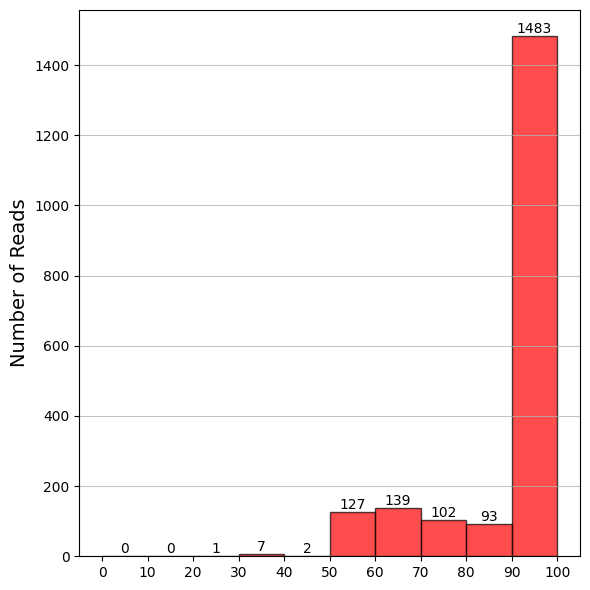

In [36]:


# Assuming reads_spanning_df is already created and has the following columns:
# 'read_name', '# of CDR', '# of CENPA enrichment domains'

# Step 1: Calculate the proportionality of # of C
#CENPA divided by # of CDR in percentage
# Handle division by zero by replacing zero # of CDR with NaN or a small number

df_mC_filtered ['Proportion_sub_CDR(%)'] = (
    df_mC_filtered ['# of sub CDR in read'] / df_mC_filtered ['# of total aggregate sub CDR spanned'] * 100
)
# Filter and print rows where Proportion_sub_CDR(%) is 50 and chromosome is 'chr10_MATERNAL'
filtered_rows = df_mC_filtered[
    (df_mC_filtered['Proportion_sub_CDR(%)'] != 100)]
     # & 
#    (df_mC_filtered['chromosome'] == 'chr10_MATERNAL')
#]

# Save the DataFrame as a CSV file
filtered_rows.to_csv("/private/groups/migalab/dan/data_analysis/HG002_figure2/b_revised_multi_region/mC_non_100_CDR.csv", index=False, sep="\t")


# Optional: Handle infinite or undefined proportions if # of CDR is zero
# For example, you can set them to zero or remove those entries
df_mC_filtered.replace([float('inf'), -float('inf')], pd.NA, inplace=True)
df_mC_filtered.dropna(subset=['Proportion_sub_CDR(%)'], inplace=True)

# Step 2: Define the bins for the histogram (0-10%, 10-20%, ..., 90-100%)
bins = range(0, 110, 10)  # This creates bins: [0-10), [10-20), ..., [90-100]

# Step 3: Plot the histogram
plt.figure(figsize=(6, 6))
n, bins, patches = plt.hist(
    df_mC_filtered['Proportion_sub_CDR(%)'],
    bins=bins,
    edgecolor='black',
    alpha=0.7,
    color='red'
)

# Step 4: Customize the plot
#plt.xlabel('Proportion of sub CDR where mCpG < top 10% percentile of chromosome methylation', fontsize=14)
plt.ylabel('Number of Reads', fontsize=14)
#plt.title('Histogram of single read sub CDR methylation < top 10% percentile of chromosome methylation', fontsize=16)
plt.xticks(bins)  # Set x-axis ticks to align with bins
plt.grid(axis='y', alpha=0.75)

# Optional: Add percentage labels above each bar
for count, bin_edge in zip(n, bins):
    plt.text(
        bin_edge + 5,       # Position text in the middle of the bin
        count,               # Y-coordinate (height of the bar)
        f'{int(count)}',     # Text to display
        ha='center',
        va='bottom',
        fontsize=10
    )

# Step 5: Display the plot

plt.tight_layout()

plt.show()


In [34]:
# Assume the dictionaries are dict1 and dict2, and the DataFrame column is df['column_name']

# Get the set of unique values in the specific column
valid_keys = set(df_mC_filtered['read names'])

 
# Filter dict1
reads_spanning_dict_mA = {key: value for key, value in reads_spanning_dict_mA.items() if key in valid_keys}

# Filter dict2
reads_CDR_mA_distribution_dict_mA = {key: value for key, value in reads_CDR_mA_distribution_dict_mA.items() if key in valid_keys}


In [35]:
import pandas as pd
data = []
for primary_key, secondary_dicts in reads_spanning_dict_mA.items():
    # Count of secondary dictionaries
    num_cdr = len(secondary_dicts)
    # Count of non-zero values in secondary dictionaries
    num_cenpa_enrichment_domains = sum(
        1 for secondary_dict in secondary_dicts if list(secondary_dict.values())[0] != 0
    )
    # Add row to data list
    data.append([primary_key, num_cdr, num_cenpa_enrichment_domains])

# Convert to DataFrame
filtered_reads_spanning_dict = pd.DataFrame(data, columns=['read_name', '# of CDR', '# of CENPA enrichment domains'])

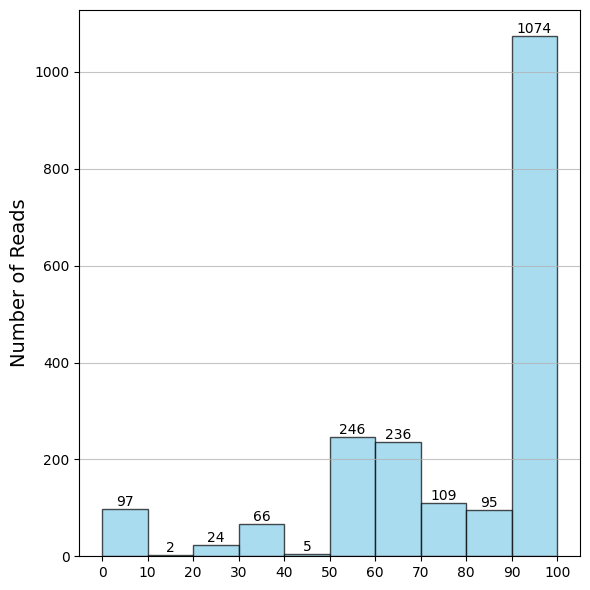

In [37]:
# Assuming reads_spanning_df is already created and has the following columns:
# 'read_name', '# of CDR', '# of CENPA enrichment domains'

# Step 1: Calculate the proportionality of # of CENPA divided by # of CDR in percentage
# Handle division by zero by replacing zero # of CDR with NaN or a small number
filtered_reads_spanning_dict['Proportion_CENPA_per_CDR (%)'] = (
    filtered_reads_spanning_dict['# of CENPA enrichment domains'] / filtered_reads_spanning_dict['# of CDR'] * 100
)

# Optional: Handle infinite or undefined proportions if # of CDR is zero
# For example, you can set them to zero or remove those entries
filtered_reads_spanning_dict.replace([float('inf'), -float('inf')], pd.NA, inplace=True)
filtered_reads_spanning_dict.dropna(subset=['Proportion_CENPA_per_CDR (%)'], inplace=True)

# Step 2: Define the bins for the histogram (0-10%, 10-20%, ..., 90-100%)
bins = range(0, 110, 10)  # This creates bins: [0-10), [10-20), ..., [90-100]

# Step 3: Plot the histogram
plt.figure(figsize=(6, 6))
n, bins, patches = plt.hist(
    filtered_reads_spanning_dict['Proportion_CENPA_per_CDR (%)'],
    bins=bins,
    edgecolor='black',
    alpha=0.7,
    color='skyblue'
)

# Step 4: Customize the plot
#plt.xlabel('Proportion of CENPA Enrichment Domains per CDR (%)', fontsize=14)
plt.ylabel('Number of Reads', fontsize=14)
#plt.title('Histogram of CENPA Enrichment Proportions per CDR', fontsize=16)
plt.xticks(bins)  # Set x-axis ticks to align with bins
plt.grid(axis='y', alpha=0.75)

# Optional: Add percentage labels above each bar
for count, bin_edge in zip(n, bins):
    plt.text(
        bin_edge + 5,       # Position text in the middle of the bin
        count,               # Y-coordinate (height of the bar)
        f'{int(count)}',     # Text to display
        ha='center',
        va='bottom',
        fontsize=10
    )

# Step 5: Display the plot

plt.tight_layout()

plt.show()


In [38]:
def get_keys_with_all_zero_values(primary_dict1, primary_dict2):
    keys_with_all_zeros = []
    
    # Get the intersection of keys to ensure both dictionaries have the key
    common_keys = set(primary_dict1.keys()) & set(primary_dict2.keys())
    
    for key in common_keys:
        sec_dicts1 = primary_dict1[key]
        sec_dicts2 = primary_dict2[key]
        
        # Check if both lists have the same length
        if len(sec_dicts1) != len(sec_dicts2):
            continue  # Skip keys where the lists are of different lengths
        
        all_zero = True  # Flag to determine if all corresponding secondary dicts have zero values
        
        # Iterate over the pairs of secondary dictionaries
        for sec_dict1, sec_dict2 in zip(sec_dicts1, sec_dicts2):
            # Check if all values are zero in both secondary dictionaries
            for k in sec_dict1.keys():
                
                if sec_dict1[k] != 0 or sec_dict2[k] != 0:
                    all_zero = False
                    break  # Found a non-zero value
            if not all_zero:
                break  # No need to check further
        
        if all_zero:
            keys_with_all_zeros.append(key)
    
    return keys_with_all_zeros

# Get the keys where all secondary dictionaries have zero values in both primary dictionaries
eliminated_keys = get_keys_with_all_zero_values(reads_spanning_dict_mA, reads_spanning_dict_mC)

# Specify the output file path
output_file_path = '/private/groups/migalab/dan/data_analysis/HG002_figure2/b_revised_multi_region/reads.txt'

# Write the eliminated keys to the file, one per line
with open(output_file_path, 'w') as f:
    for key in eliminated_keys:
        f.write(f"{key}\n")


NameError: name 'reads_spanning_dict_mA' is not defined

In [20]:
def get_primary_keys_with_zero_secondary_keys(primary_dict1, primary_dict2):
    keys_to_add = []

    # Get the intersection of primary keys to ensure both dictionaries have the key
    common_keys = set(primary_dict1.keys()) & set(primary_dict2.keys())

    for key in common_keys:
        sec_dicts1 = primary_dict1[key]
        sec_dicts2 = primary_dict2[key]

        # Check if both lists have the same length
        if len(sec_dicts1) != len(sec_dicts2):
            continue  # Skip keys where the lists are of different lengths

        # Flag to determine if the primary key should be added
        add_primary_key = False

        # Iterate over the pairs of secondary dictionaries
        for idx in range(len(sec_dicts1)):
            sec_dict1 = sec_dicts1[idx]
            sec_dict2 = sec_dicts2[idx]

            # Find the common secondary keys
            common_sec_keys = set(sec_dict1.keys()) & set(sec_dict2.keys())

            for k in common_sec_keys:
                if sec_dict1[k] == 0 and sec_dict2[k] == 0:
                    # As long as a secondary key meets the condition, add the primary key
                    keys_to_add.append(key)
                    add_primary_key = True
                    break  # Break out of the inner loop since we've added the primary key
            if add_primary_key:
                break  # Break out of the outer loop for this primary key

    return keys_to_add

# Get the primary keys where any secondary key meets the condition
keys_to_write = get_primary_keys_with_zero_secondary_keys(reads_spanning_dict_mA, reads_spanning_dict_mC)

# Specify the output file path
output_file_path = '/private/groups/migalab/dan/data_analysis/HG002_figure2/b_revised_multi_region/reads.txt'

# Write the keys to the file, one per line
with open(output_file_path, 'w') as f:
    for key in keys_to_write:
        f.write(f"{key}\n")


In [12]:
import pysam

# Paths to your files
exclude_reads_file = '/private/groups/migalab/dan/data_analysis/HG002_figure2/b_revised_multi_region/reads.txt'  # Path to the text file with read names to exclude
input_bam = '/private/groups/migalab/dan/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1/20240611_1126_1H_PAW33460_814408d8/pod5/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1_5mA_6mC_winnowmap_MD_mA_mC.bam'  # Path to the input BAM file
output_bam = '/private/groups/migalab/dan/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1/20240611_1126_1H_PAW33460_814408d8/pod5/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1_5mA_6mC_winnowmap_MD_mA_mC_ch5_MATERNAL_filtered.bam'  # Path for the output BAM file

# Step 1: Read the read names to exclude into a set for fast lookup
with open(exclude_reads_file, 'r') as f:
    exclude_reads = set(line.strip() for line in f)

# Step 2: Open the input BAM file for reading
with pysam.AlignmentFile(input_bam, 'rb') as infile:
    # Step 3: Open the output BAM file for writing, using the same header as the input
    with pysam.AlignmentFile(output_bam, 'wb', header=infile.header) as outfile:
        # Step 4: Iterate over each read in the input BAM file
        for read in infile:
            # Step 5: Write the read to the output file if:
            # - It's not in the exclude list
            # - It's mapped to 'chr5_MATERNAL'
            if read.query_name not in exclude_reads and read.reference_name == 'chr5_MATERNAL':
                outfile.write(read)


[W::hts_idx_load3] The index file is older than the data file: /private/groups/migalab/dan/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1/20240611_1126_1H_PAW33460_814408d8/pod5/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1_5mA_6mC_winnowmap_MD_mA_mC.bam.csi
